# 구글 드라이브 연동

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


# File I/O
- wirte_FileName :  directory 내 jpg 파일 리스트 txt 생성

In [0]:
from os import listdir
import cv2
import imghdr ## image 파일 판단

In [0]:
def write_FileName(img_path, base_path = "./", name = "train.txt"):
    """
    지정된 경로에 저장된 이미지 파일의 이름을 텍스트 파일에 저장
    param:
    1. img_path :  저장된 이미지 파일 경로
    2. base_path : 이미지 파일 이름이 저장될 장소
    3. name : 이미지 파일 이름이 저장된 텍스트 파일의 이름
    """   
    img_names = listdir(img_path)
    path = list()
    
    for img_name in img_names:
        if cv2.imread(img_name) is not None:
            path.append(img_name)            
    base_path += name
    with open(name, "wt") as file:
        for file_name in path:
            file.write(file_name + '\n')

In [0]:
write_FileName(".")

# Sample Image Download

In [0]:
# test lena 사진 다운로드
!wget https://upload.wikimedia.org/wikipedia/ko/thumb/2/24/Lenna.png/220px-Lenna.png
    
# lena 파일 이름 바꾸기
!mv 220px-Lenna.png lena.png

--2019-07-23 13:14:18--  https://upload.wikimedia.org/wikipedia/ko/thumb/2/24/Lenna.png/220px-Lenna.png
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.153.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.153.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 101968 (100K) [image/png]
Saving to: ‘220px-Lenna.png’

220px-Lenna.png     100%[===================>]  99.58K  --.-KB/s    in 0.04s   

2019-07-23 13:14:23 (2.36 MB/s) - ‘220px-Lenna.png’ saved [101968/101968]



# data augmentation
- flip
- scale
- rotate

In [0]:
import numpy as np
import cv2
import sys
import os
import random
import copy

In [0]:
def RandomFlip(img, bboxes, mode = 1, p = 1.0):
    #mode : 0 상하 반전 1 좌우 반전
    src = copy.deepcopy(img)
    bbox = copy.deepcopy(bboxes)
    
    if random.random() < p:
        print("flip 실행")
        dst = cv2.flip(img, mode)
        
        for i in range(len(bbox)):
            if mode == 0:
                bbox[i][2] = 1 - bbox[i][2]
            elif mode == 1:
                bbox[i][1] = 1 - bbox[i][1]
        
        return dst , bbox
    
    print("flip 미실행")
    return raw_img, bboxes

def RandomResize(img, bbox, scale = 0.7, p = 1.0):
    src = copy.deepcopy(img)
    bbox = copy.deepcopy(bbox)
    
    
    if random.random() < p:
        return src, bbox
    
    
    dsize = (int(src.shape[1] * scale), int(src.shape[0] * scale))
    dst = np.zeros(src.shape)
    
    src = cv2.resize(src, dsize, interpolation=cv2.INTER_AREA)
    
    for i in range(src.shape[0]):
        for j in range(src.shape[1]):
            dst[i][j]= src[i][j]
    
    for i in range(len(bbox)):
        for j in range(5):
            if i != 0:
                bbox[i][j] = bbox[i][j] * scale
            
    return dst, bbox

def RandomRotate(img, angle, p = 1.0):
    if random.random() < p:
        print("rotate 실행")
        return img
        
    H = img.shape[0]
    W = img.shape[1]
    matrix = cv2.getRotationMatrix2D((W/2,H/2), angle, scale)
    rotated = cv2.warpAffine(img, matrix, (W,H))  
    
    return rotated

def SaveImage(img, bbox, save_path, name):
    
    cv2.imwrite(save_path+name+".jpg", img)
    
    with open(name+".txt", 'w') as f:
        for i in range(len(bbox)):
            for j in range(5):
                f.write(str(bbox[i][j])+" ")
                
            f.write("\n")


In [0]:
bbox = [[1,2,3,4,5],[6,7,8,9,10]]
raw_img = cv2.imread("lena.png")

SaveImage(raw_img, bbox, "./", "train")

In [0]:
raw_bbox = bbox([0, 0.5, 0.5, 0.5, 0.5])
raw_img = cv2.imread("lena.png")

start, end = yoloTocv2(raw_img.shape, raw_bbox.bbox)
cv2.rectangle(raw_img, start, end,(255,0,0), 1)
cv2_imshow(raw_img)

resized_img , resized_bbox = RandomResize(raw_img, raw_bbox.bbox)
start, end = yoloTocv2(resized_img.shape, resized_bbox)
cv2.rectangle(resized_img, start, end,(255,0,0), 1)

cv2_imshow(resized_img)

## bbox

In [0]:
import numpy as np
import cv2
import sys
import os
from google.colab.patches import cv2_imshow
import random
import copy

In [0]:
class bbox(object):
    def __init__(self, x):
        # bbox : class, x, y, width, height
        self.bbox = x
#         print(self.bbox)
        
    def read(self, path):
        with open("path", 'rt') as file:
            for line in file.readline():
                line = line.split()
        
        pass
        

In [0]:
def yoloTocv2(shape, box):
    height = shape[0]
    width = shape[1]
    
    coords = [box[1] - box[3]/2, box[2] - box[4]/2, box[1] + box[3]/2, box[2] + box[4]/2 ]
    
    for i, coord in enumerate(coords):
        if coord > 1.0:
            coords[i] =  1.0
        elif coord < 0:
            coords[i] = 0
        
    start = (int(coords[0]*width),int(coords[1]*height))
    end = (int(coords[2]*width), int(coords[3]*height))
    
    return start, end

flip 실행
[0.  0.7 0.5 0.3 0.6]


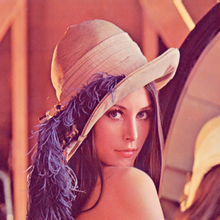

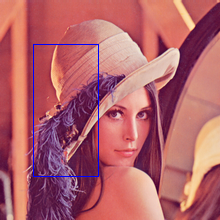

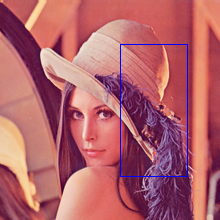

False

In [0]:
## flip example

flip_img, flip_bbox = RandomFlip(raw_img, bbox1.bbox, 1, p = 1)
print(flip_bbox)

start, end = yoloTocv2(flip_img.shape, flip_bbox)

cv2.rectangle(flip_img, start, end,(255,0,0), 1)

# 원본 이미지
cv2_imshow(raw_img)

#
cv2_imshow(img)

#
cv2_imshow(flip_img)

img is flip_img